In [61]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

100%|██████████| 70/70 [00:00<00:00, 269112.08it/s]

Trades: 2


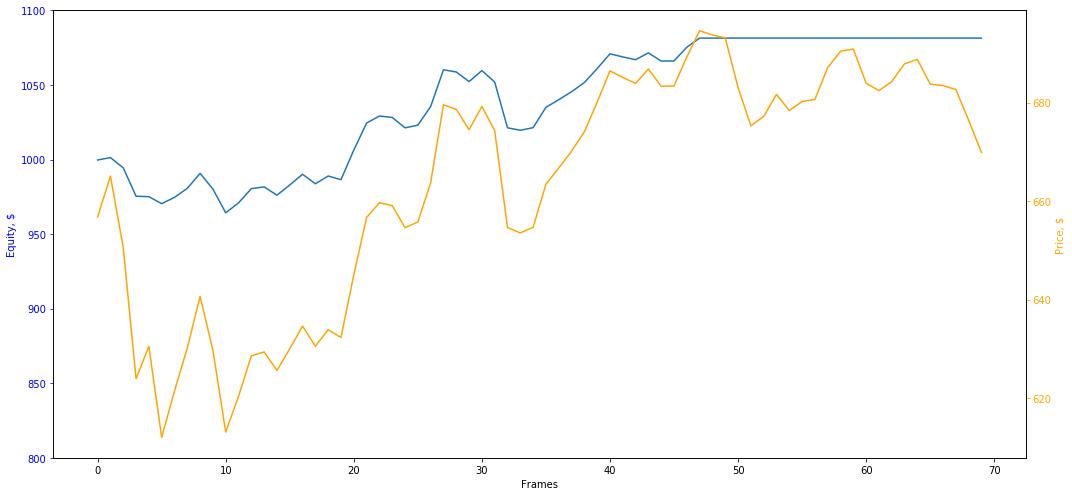

In [170]:
history = np.array(pickle.load(open('eth_train_ohlc.p','rb')))
decisions = [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 
             0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

batch_mode = True
two_day_exit = False

fee = 0.002 #%*100
funds = 1000. #USD
deal_batch = 150. #USD
funds_crypto = 0. #BTC

state = None
trades = 0
funds_history = []
enter_moments = []
exit_moments = []
equity = []
max_price = 0
SL = 0.05

for t in tqdm(range(len(history))):
    if decisions[t] == 1: 
        if not batch_mode:
            if state == None:
                state = 'long'
                funds_crypto = (1-fee)*funds/float(history[t][-1])
                enter_price = float(history[t][-1])
                max_price = enter_price
                enter_moments.append(t)
                enter_time = t
                funds = 0.
        else:
            if funds > 0:
                if state == None:
                    enter_price = float(history[t][-1])
                    max_price = enter_price
                    enter_time = t
                state = 'long'
                funds_crypto += (1-fee)*min(deal_batch,funds)/float(history[t][-1])
                funds -= min(deal_batch,funds)
                enter_moments.append(t)
    
    if state == 'long' and history[t][-1] > max_price:
        max_price = history[t][-1]
    
    drawdown = (history[t][-1]-max_price)/max_price
    position = (history[t][-1]-enter_price)/enter_price

    if (position >= 0.1 or drawdown <= -SL or (two_day_exit and t-enter_time == 24)) and state == 'long':
        exit_moments.append(t)
        state = None
        trades += 1
        funds = (1-fee)*funds_crypto*float(history[t][-1])+funds
        funds_crypto = 0.
        
    if funds_crypto != 0:
        equity.append(funds_crypto*history[t][-1]+funds)
    else:
#         equity.append(equity[-1])
        equity.append(funds)
            
    funds_history.append((1-fee)*funds_crypto*float(history[t][-1])+funds)

#         print("Profit:",profit,"vs buy-and-hold profit:",(float(self.history[-1][-1])-float(self.history[0][2]))/float(self.history[0][2]))
#         print("Sharpe ratio:",np.mean(profit_history)/np.std(profit_history))
print("Trades:",trades)
# plt.figure(figsize=(17,8))
# # equity = (np.array(funds_history)-funds_history[0])/funds_history[0]
# plt.plot(np.array(equity)-350,label='Equity')
# # C = np.array((history[:,-1]-history[0,-1])/history[0,-1],dtype=float)
# C = history[:,-1]
# plt.plot(C,label='Price')
# plt.plot(enter_moments,C[enter_moments],'^g')
# plt.plot(exit_moments,C[exit_moments],'vr')

# plt.xlabel("Frames")
# plt.ylabel("Equity, $")
# plt.legend(loc='best')
# plt.grid()

fig, ax1 = plt.subplots()
fig.set_size_inches(15,7)
ax1.plot(np.array(equity),label='Equity')
ax1.set_xlabel("Frames")
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Equity, $', color='b')
ax1.set_ylim(800,1100)
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(C,label='Price',c='orange')
ax2.set_ylabel('Price, $', color='orange')
ax2.tick_params('y', colors='orange')

fig.tight_layout()
plt.show()

# Data Preparation

In [30]:
import os
import pandas as pd
import numpy as np
import pickle

In [9]:
path_data = os.path.join('..', 'data')
data = pd.read_csv(os.path.join(path_data, 'train', 'tickers_train.csv'))

In [12]:
df_y_train = pd.pivot_table(data, 
    values=['priceBtc', 'priceUsd', 'volume'], 
    index=['datetime'],
    columns=['ticker'])#.head()
df_y_train.sort_index(inplace=True)
df_y_train.index = pd.Series(pd.to_datetime(np.array(df_y_train.index))).apply(lambda x: x.timestamp())
print('index dif :', np.unique(np.array(df_y_train.index[1:]) - np.array(df_y_train.index[:-1])))
df_y_train.head()

index dif : [7200.]


priceBtc                                                        \
ticker           $PAC       1ST 1WO       ABT      ACAT       ACC       ACT   
1.519862e+09      NaN  0.000029 NaN  0.000114  0.000001  0.000100  0.000035   
1.519870e+09      NaN  0.000028 NaN  0.000115  0.000001  0.000107  0.000035   
1.519877e+09      NaN  0.000029 NaN  0.000115  0.000001  0.000110  0.000036   
1.519884e+09      NaN  0.000029 NaN  0.000115  0.000001  0.000103  0.000035   
1.519891e+09      NaN  0.000027 NaN  0.000114  0.000001  0.000100  0.000035   

                                        ...          volume             \
ticker             ADA       ADB ADH    ...             XVG        XZC   
1.519862e+09  0.000030  0.000002 NaN    ...      18653700.0  3852160.0   
1.519870e+09  0.000029  0.000002 NaN    ...      18850700.0  3857900.0   
1.519877e+09  0.000029  0.000002 NaN    ...      18282600.0  4010780.0   
1.519884e+09  0.000028  0.000002 NaN    ...      18203200.0  3993010.0   
1.519891e+09  0.000028  0.000002 NaN    ...      17933400.0  3689700.0   

                                                                            \
ticker                ZCL ZCO         ZEC        ZEN        ZIL        ZLA   
1.519862e+09  109027000.0 NaN  54766800.0  2259440.0  8196340.0  1453870.0   
1.519870e+09  106212000.0 NaN  53604900.0  2577900.0  7909660.0  1327050.0   
1.519877e+09  104332000.0 NaN  53318000.0  2740920.0  7671810.0  1137000.0   
1.519884e+09  109475000.0 NaN  53300600.0  2953900.0  7742030.0  1103730.0   
1.519891e+09   99679900.0 NaN  51532800.0  2749000.0  7918250.0  1096540.0   

                                    
ticker              ZPT        ZRX  
1.519862e+09  3449770.0  8127100.0  
1.519870e+09  3444390.0  7962720.0  
1.519877e+09  2562270.0  7980440.0  
1.519884e+09  5068710.0  7554380.0  
1.519891e+09  5489550.0  7468790.0  

[5 rows x 1527 columns]

In [32]:
eth = np.matrix(df_y_train['priceUsd']['ETH']).reshape(-1,1)

In [36]:
ohlc = np.repeat(eth, 4, axis=1).tolist()[-70:]

In [39]:
pickle.dump(ohlc,open('eth_train_ohlc.p','wb'))

In [33]:
len(eth)

732

In [34]:
decisions = [1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [35]:
len(decisions)

70